# Nesne Yerelleştirme
 

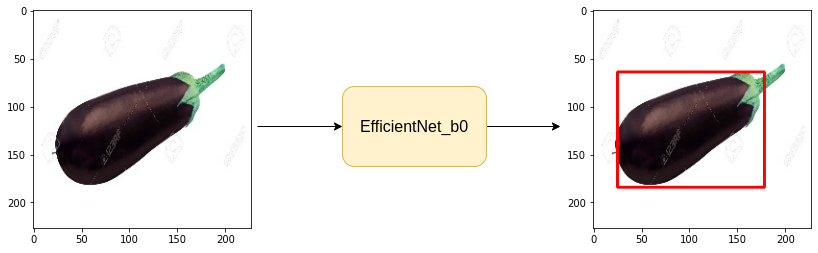

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-pre0rf0c
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pre0rf0c
  Resolved https://github.com/albumentations-team/albumentations to commit 7e49d472b451c4f25ae74d1a67503c8b3313eaf0
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125521 sha256=d948059228a0d2f681c4f20e4110978ac852d2697b6bea799ea918e683da127b
  Stored in directory: /tmp/pip-ephem-wheel-cache-nmjpyjr1/wheels/f3/4a/7f/67b055656bec4d4aaa8963cfc93678f6f2906b2d72054a1268
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
L

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 14.43 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Konfigürasyon

In [44]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16

IMG_SIZE = 140

LR = 0.001
EPOCHS = 4
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# dataseti anlamak..

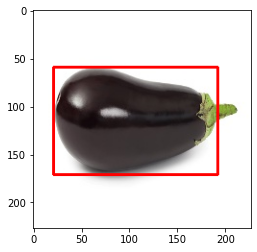

In [15]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [17]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state = 42)

# Augmentations

In [18]:
import albumentations as A

In [20]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields = ['class_labels']))

# Özel Veri Kümesi Oluşturma

In [21]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin,ymin,xmax,ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]


    img = torch.from_numpy(img).permute(2,0,1)/255.0
    bbox = torch.Tensor(bbox)

    return img,bbox


In [22]:
trainset = ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [23]:
print(f'Toplam Örnek Sayısı(trainset): {len(trainset)}')
print(f'Toplam Örnek Sayısı(validset): {len(validset)}')

Toplam Örnek Sayısı(trainset): 148
Toplam Örnek Sayısı(validset): 38


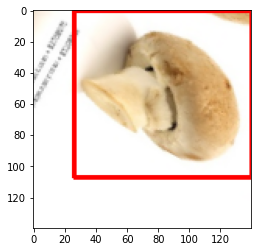

In [26]:
img, bbox = trainset[100]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Veri kümesini toplu işlere yükleme

In [28]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle=False)

In [29]:
print(" trainloader : {}".format(len(trainloader)))
print(" validloader : {}".format(len(validloader)))

 trainloader : 10
 validloader : 3


In [31]:
for images, bboxes in trainloader:
  break;
print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Modelimizi Oluşturalım

In [32]:
from torch import nn 
import timm

In [34]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

  def forward(self,images, gt_bboxes = None):

    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes,gt_bboxes)
      return bboxes, loss

    return bboxes


In [38]:
model = ObjLocModel()
#model.to(DEVICE)

In [39]:
random_img = torch.rand(1,3,140,140)
model(random_img).shape

torch.Size([1, 4])

# Train ve Eval Function Oluşturma

In [40]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images, gt_bboxes

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [42]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()

  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images, gt_bboxes

      bboxes, loss = model(images, gt_bboxes)

      total_loss += loss.item()

    return total_loss / len(dataloader)


# Eğitim

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [45]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("model ağırlıklarını kaydettim.")
    best_valid_loss = valid_loss

  print(f"epoch : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

model ağırlıklarını kaydettim.
epoch : 1 train_loss : 5352.217260742187 valid_loss : 3236.7876790364585


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

model ağırlıklarını kaydettim.
epoch : 2 train_loss : 2082.3278686523436 valid_loss : 1068.424580891927


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

model ağırlıklarını kaydettim.
epoch : 3 train_loss : 1290.776513671875 valid_loss : 597.4876098632812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

model ağırlıklarını kaydettim.
epoch : 4 train_loss : 896.4006591796875 valid_loss : 172.84094746907553


# Sonuç

In [50]:
import utils

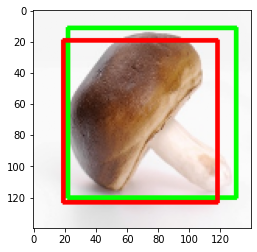

In [54]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
with torch.no_grad():
  image, gt_bbox = validset[2]
  image = image.unsqueeze(0)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)